
Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



# Loading precomputed Myrtle-10 kernels from CIFAR-10

Loading full CIFAR-10 kernels requires large RAM (+32GB)




In [ ]:
# Imports
from tensorflow.io import gfile
import os
import numpy as np
import itertools
import concurrent.futures
import matplotlib.pyplot as plt

In [ ]:
# External
from google.colab import auth
try:
  auth.authenticate_user()
except:
  print('Colab authentication failed!!')

KERNEL_PATH = 'gs://neural-tangents-kernels/infinite-uncertainty/kernels/myrtle-10'


print('Corruption directory names:', gfile.listdir(KERNEL_PATH)[:7])

Colab authentication failed!!
Corruption directory names: ['brightness_1', 'brightness_2', 'brightness_3', 'brightness_4', 'brightness_5', 'clean', 'contrast_1']


# Loading computed kernels

In [ ]:
# Convenient packaging for kernels and labels
class LoadedKernel:

  def __init__(self,
               kernel_type,
               n_train_load=5000,
               kernel_path='/tmp/kernels',
               dtype=np.float32):
    self.kernel_path = kernel_path
    self.k_type = kernel_type

    # Load kernels by block size of 5000
    assert n_train_load % 5000 == 0
    self.n_train_load = n_train_load
    self.max_train_id = int(np.ceil(n_train_load / 5000))
    self.clean_ids = list(
        filter(
            lambda x: x[0] <= x[1],
            itertools.product(
                list(range(self.max_train_id)) + [10, 11],
                list(range(self.max_train_id)) + [10, 11])))

    self.test_ids = list(
        filter(lambda x: x[0] <= x[1],
               itertools.product(list(range(self.max_train_id)), [10, 11])))
    self.dtype = dtype
    self.kernel = np.zeros(
        shape=(5000 * (self.max_train_id + 2), 5000 * (self.max_train_id + 2)),
        dtype=self.dtype)
    self._load_labels()
    self._load_kernel()

  def _update_kernel(self, test_type, kernel_type, ids):
    filedir = os.path.join(self.kernel_path, test_type)
    assert gfile.exists(filedir), f"File path {filedir} doesn't exsit"
    filepath = os.path.join(filedir, kernel_type)

    def _update_kernel_from_indicies(index):
      row, col = index
      # Loading based on 60k x 60k matrix
      with gfile.GFile(f'{filepath}-{row}-{col}', 'rb') as f:
        val = np.load(f).astype(self.dtype)

      # Adjust row/col index based on self.n_train_load
      if row >= self.max_train_id:
        row += self.max_train_id - 10
      if col >= self.max_train_id:
        col += self.max_train_id - 10
      self.kernel[row * 5000:(row + 1) * 5000,
                  col * 5000:(col + 1) * 5000] = val
      if col > row:
        self.kernel[col * 5000:(col + 1) * 5000,
                    row * 5000:(row + 1) * 5000] = val.T

    with concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:
      executor.map(_update_kernel_from_indicies, ids)

  def _load_kernel(self):
    self._update_kernel('clean', self.k_type, self.clean_ids)

  def _load_labels(self):
    with gfile.GFile(os.path.join(self.kernel_path, 'clean', 'labels'),
                     'rb') as f:
      self.labels = np.load(f)
    self.labels = np.concatenate(
        [self.labels[:self.max_train_id * 5000], self.labels[-10000:]])

  def update_test(self, test_type):
    self._update_kernel(test_type, self.k_type, self.test_ids)

In [ ]:
# Check kernels for sanity
def kernel_inference(kdd, ktd, y_train, diag_reg):
  return ktd.dot(
      np.linalg.solve(
          kdd + diag_reg * np.mean(np.diag(kdd)) * np.eye(kdd.shape[0]),
          y_train))


def run_kerenel_inference(kernel, n_train, seed=0):
  kernel_train_size = kernel.kernel.shape[0] - 10000
  assert kernel_train_size >= n_train
  np.random.seed(seed)
  support_idx = np.random.choice(kernel_train_size, n_train, replace=False)
  train_labels = kernel.labels[:kernel_train_size]
  test_labels = kernel.labels[kernel_train_size:]
  support_y = train_labels[support_idx]
  kdd = kernel.kernel[support_idx, :][:, support_idx]
  ktd = kernel.kernel[kernel_train_size:, :][:, support_idx]
  accs = []
  predictions = []
  diag_regs = np.logspace(-8, 2, 20)
  for diag_reg in diag_regs:
    pred = kernel_inference(kdd, ktd, support_y, diag_reg)
    acc = np.mean(np.argmax(pred, axis=-1) == np.argmax(test_labels, axis=-1))
    predictions.append(pred)
    accs.append(acc)
  return np.array(predictions), diag_regs, np.array(accs)

In [ ]:
%%time
N_TRAIN_LOAD = 5000
KERNEL_TYPE = 'ntk'  # 'nngp', 'ntk

Kernel = LoadedKernel(
    n_train_load=N_TRAIN_LOAD,
    kernel_type=KERNEL_TYPE,
    kernel_path=KERNEL_PATH,
    )

CPU times: user 2.51 s, sys: 1.47 s, total: 3.98 s
Wall time: 10 s


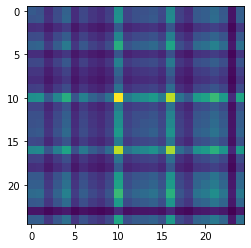

In [ ]:
plt.imshow(Kernel.kernel[:25, :25])
plt.show()

In [ ]:
corruption_name = 'speckle_noise'  #@param ['brightness', 'contrast', 'defocus_blur', 'elastic', 'fog', 'frost', 'frosted_glass_blur', 'gaussian_blur', 'gaussian_noise', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']

n_train = 500  #@param
print(f'n_train = {n_train}, corruption = {corruption_name}')
for c_level in range(0, 6):
  if c_level == 0:
    Kernel.update_test(f'clean')
  else:
    Kernel.update_test(f'{corruption_name}_{c_level}')
  preds, regs, accs = run_kerenel_inference(Kernel, n_train)
  print(f'Corruption Level {c_level}, Acc: {np.max(accs)}')

n_train = 500, corruption = speckle_noise
Corruption Level 0, Acc: 0.5024
Corruption Level 1, Acc: 0.2831
Corruption Level 2, Acc: 0.2046
Corruption Level 3, Acc: 0.1831
Corruption Level 4, Acc: 0.1566
Corruption Level 5, Acc: 0.1418
